### Проект 3. Компьютер говорит «Нет» 

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_validate
from math import log as log
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
pd.options.mode.chained_assignment = None

# этот блок закомментирован так как используется только на kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# # # этот блок закомментирован так как используется только локальной машине
# from importlib import reload
# print(os.listdir('./data'))
# PATH_to_file = './data/'

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('09/02/2021')

### Функции для оценки качества модели

In [3]:
def plot_confusion_matrix(y_true, y_pred, font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j] + '\n' + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def confusion_matrix_f(columns, d_y, d_y_pred, font_scale=1, normalize=False):
    class_names = np.array(columns, dtype='U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names,
                          title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names, normalize=True,
                              title='Нормализованная матрица ошибок')

    plt.show()
    return


def PR_curve_with_area(d_y_true, d_y_pred_prob, font_scale=1):
    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)

    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return


def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color='darkblue')
    plt.plot([0, num_folds - 1], [avg_metric_train, avg_metric_train], color='blue',
             label='среднее трен. значений ', marker='.', lw=2, ls='--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color='red')
    plt.plot([0, num_folds - 1], [avg_metric_test, avg_metric_test], color='lightcoral',
             label='среднее тест. значений ', marker='.', lw=2, ls='--')

    plt.plot([0, num_folds - 1], [d_value_metric, d_value_metric], color='grey',
             label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train, avg_metric_test) + 1.5 * max(std_metric_train, std_metric_test)
    y_min = min(avg_metric_train, avg_metric_test) - 3 * max(std_metric_train, std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color=color_text)
    plt.ylabel(d_name_metric, fontsize=15, color=color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах',
              color=color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min + 0.5 * max(std_metric_train, std_metric_test)
    plt.text(0, y_min_text,
             f'{d_name_metric} на трейне = {round(avg_metric_train, 3)} +/- '
             f'{round(std_metric_train, 3)} \n{d_name_metric} на тесте    = {round(avg_metric_test, 3)} +/- '
             f'{round(std_metric_test, 3)} \n{d_name_metric} до CV        = {round(d_value_metric, 3)}',
             fontsize=15)
    plt.show()
    return


def model_coef(d_columns, d_model_coef_0):
    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True, inplace=True)

    return temp_df.loc[:, ['имя признака', 'коэффициент модели']]

def print_metrics():
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('F1: %.4f' % f1_score(y_test, y_pred))

def ROC_curve_with_area(d_y_true, d_y_pred_prob, font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

## 2. Импорт данных

In [4]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
#df_train = pd.read_csv('train.csv')
#df_test = pd.read_csv('test.csv')

In [5]:
df_train.info()
display(df_train.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


In [6]:
df_test.info()
display(df_test.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


Резюме: в обоих датасетах пропуски есть только по столбцу education

In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

## 3. Предварительный анализ данных

Посмотрим на объединенный датафрейм:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Посмотрим сколько уникальных значений в датасете:

In [9]:
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
Train                    2
dtype: int64

##### Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой  - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 6 числовых. Всего пропусков 272 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезностей. В бинарных признаках наше целевая переменная  default и искуственно добавленный признак тренировочной части датасета Train  

Описания полей датасета
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [10]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (8)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

## 4. Анализ по переменным
---

### 1. Числовые переменные

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


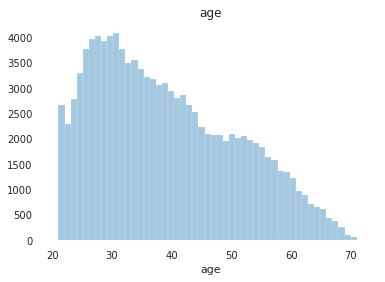

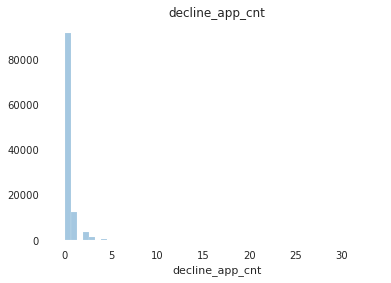

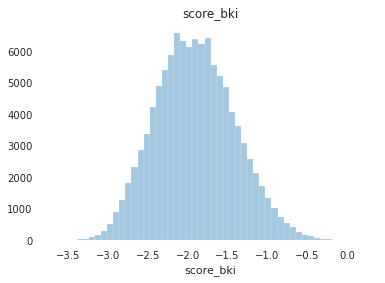

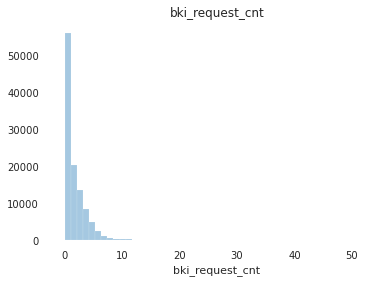

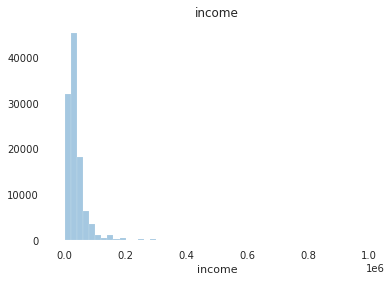

In [11]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    #sns.distplot(np.log(df[i]), kde = False, rug=False)
    plt.title(i)
    plt.show()

Распределения всех числовых переменных кроме score_bki имеют тяжёлый правый хвост, score_bki распределено нормально

Построим графики распределения логарифмированных переменных.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


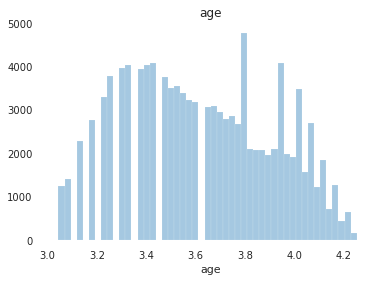

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


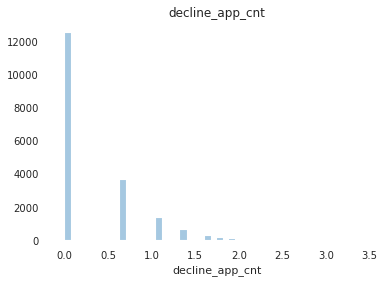

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


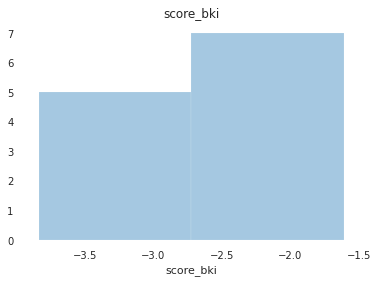

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


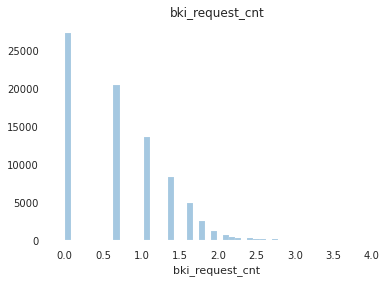

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


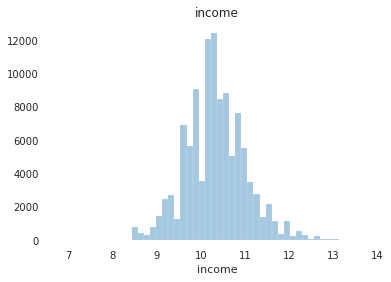

In [12]:
for i in num_cols:
    plt.figure()
    sns.distplot(np.log(df[i][df[i] > 0].dropna()), kde = False, rug=False)
    plt.title(i)
    plt.show()

Построим boxplot для выявления выбросов:

In [13]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot( y=column,
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:20])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

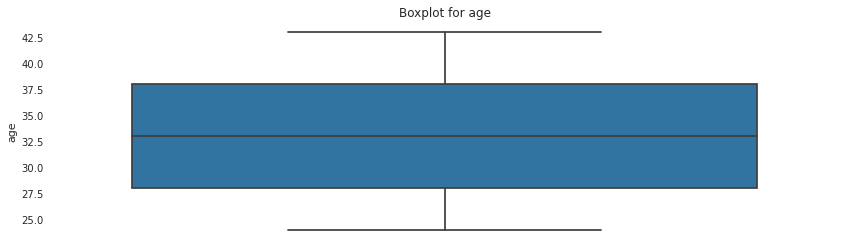

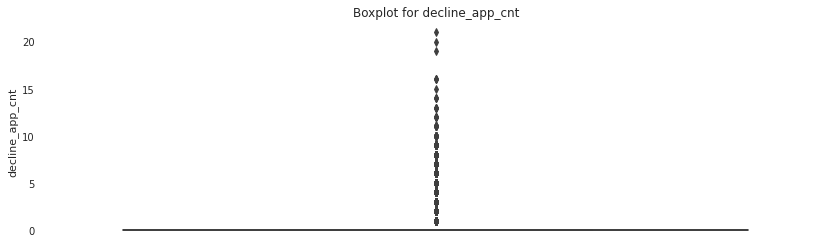

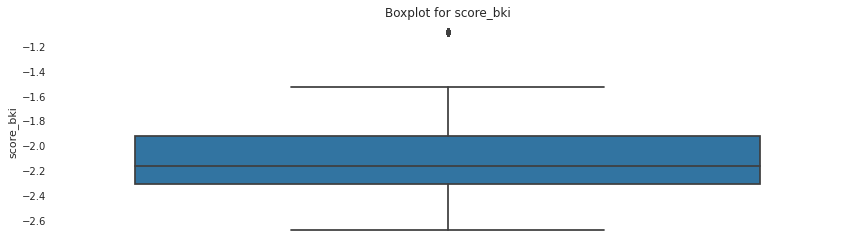

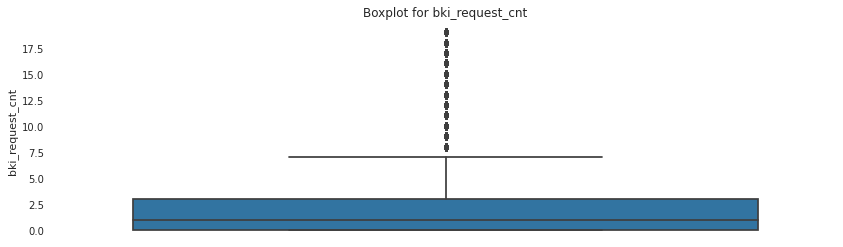

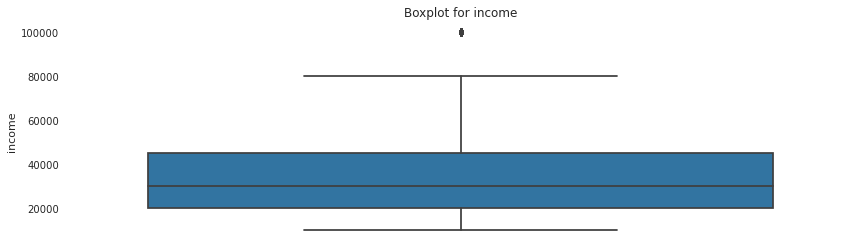

In [14]:
for col in num_cols:
    get_boxplot(col)

Самое существенное кол-во выбросов есть по признака decline_app_cnt, так же есть выбросы по bki_request_cnt. Пока не будем удалять выбросы из датасета.

Посмотрим по этим двум принакам основные стат.пказатели:

In [15]:
df['decline_app_cnt'].describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [16]:
df['bki_request_cnt'].describe()

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

Посмотрим на Skewness до логарифмирования:

In [17]:
for i in num_cols:
    print(i,df[i].skew())

age 0.4802480831391855
decline_app_cnt 6.493006695946564
score_bki 0.19398729756537827
bki_request_cnt 3.082728151937048
income 7.503020095049897


По всем признакам кроме score_bki можно взять логарифм от признака:

In [18]:
df['age'] = np.log(df['age'] + 1)
df['income'] = np.log(df['income'] + 1)
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

Посмотрим как поменялось skewness после логарифмирования:

In [19]:
for i in num_cols:
    print(i,df[i].skew())

age 0.05015190556552752
decline_app_cnt 2.505051536088294
score_bki 0.19398729756537827
bki_request_cnt 0.18033177167655778
income 0.3590057394350352


Перекос снился существенно по всем признакам кроме decline_app_cnt. По этом признаку логарифмирование не дало больших изменений в распределении.

### 2. Категориальные переменные

#### sna

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


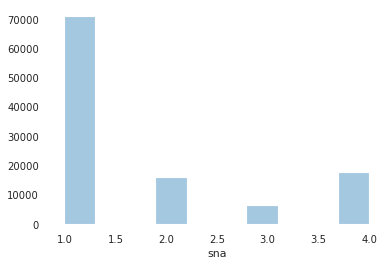

In [20]:
plt.figure()
sns.distplot(df['sna'], kde = False, rug=False, bins=10)
plt.show()

In [21]:
df['sna'].describe()

count    110148.000000
mean          1.731588
std           1.122652
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64

Резюме - sna: Пропусков нет. Всего 4 значения в признаке.

#### first_time

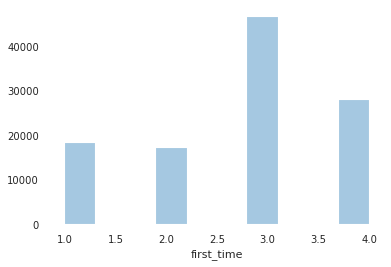

In [22]:
plt.figure()
sns.distplot(df['first_time'], kde = False, rug=False, bins=10)
plt.show()

In [23]:
df['first_time'].describe()

count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64

In [24]:
df['first_time'].value_counts(dropna=False)

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

Резюме - first_time: Пропусков нет. Всего 4 значения в признаке.

#### region_rating

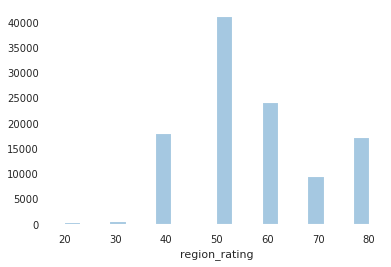

In [25]:
plt.figure()
sns.distplot(df['region_rating'], kde = False, rug=False, bins=20)
plt.show()

In [26]:
df['region_rating'].value_counts(dropna=False)

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

In [27]:
df['region_rating'].describe()

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

Резюме - region_rating: Пропусков нет. Есть 7 категорий в рейтинге, среднее -50.

#### education

<AxesSubplot:>

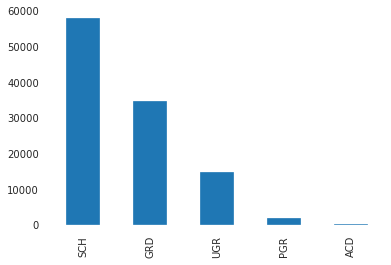

In [28]:
df['education'].value_counts().plot.bar()

In [29]:
# заполним пропуски в education
# переменной education 307 (0.4%) пропущенных значений 
# заполним пропуски самым популярным значением 
df['education'] = df['education'].fillna('SCH')

### 3. app_date - числовой ряд

In [30]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [31]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [32]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

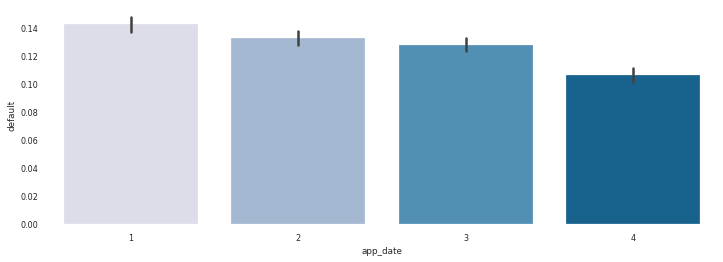

In [33]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

<AxesSubplot:xlabel='client_id', ylabel='days'>

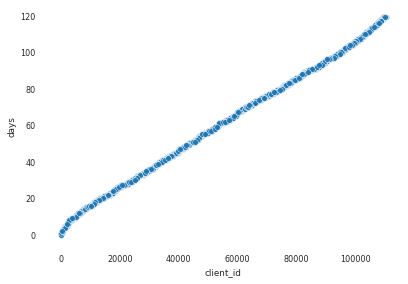

In [34]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

### Оценим корреляцию Пирсона для непрерывных переменных по формуле:

<AxesSubplot:>

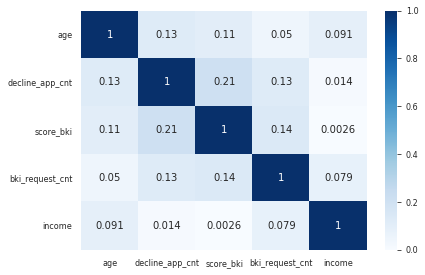

In [35]:
sns.heatmap(df[num_cols].corr().abs(), annot=True, vmin=0, vmax=1,cmap='Blues')

Резюме - сильно скорелированных между собой признаков нет, все берем в работу

### Оценка значимости числовых переменных

<AxesSubplot:title={'center':'Значимость непрерывных переменных по ANOVA F test'}>

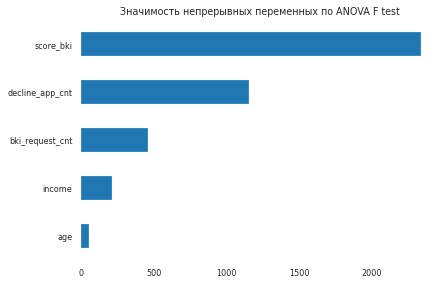

In [36]:
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Резюме - оценка плательщика БКИ (score_bki) самый значимый показатель по ANOVA F test, потом кол-во отказанных заявок (declain_app_cnt) и в конце возраст (age)

### Обработаем категориальные и бинарные переменные

Для остальных бинарных признаков также мы будем использовать LabelEncoder

In [37]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [38]:
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0.0,1,31
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0.0,1,70
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0.0,1,31
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0.0,1,22
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0.0,1,107


In [39]:
df['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [40]:
df['education'] = df['education'].map({'SCH': 1,'UGR': 2,
            'GRD': 3,'PGR': 4,'ACD': 5})
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days
0,25905,2014-02-01,1,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0.0,1,31
1,63161,2014-03-12,1,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0.0,1,70
2,25887,2014-02-01,1,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0.0,1,31
3,16222,2014-01-23,1,0,3.988984,0,0,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0.0,1,22
4,101655,2014-04-18,3,1,3.891820,0,0,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0.0,1,107


### Посмотрим на значимость категориальных и бинарных переменных 

['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport']


<AxesSubplot:title={'center':'Значимость бин. и категор. переменных по Mutual information test'}>

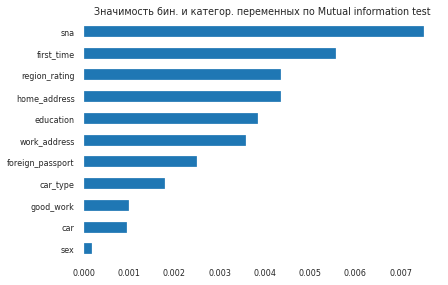

In [41]:
all_cat_and_bin_cols = cat_cols+bin_cols
print(all_cat_and_bin_cols)

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Резюме - Самым значимым признаком является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time), потом идет рейтинг региона (region_rating) и в конце пол (sex).

## 5. Подготовка данных к машинному обучению

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  int64         
 4   age               110148 non-null  float64       
 5   car               110148 non-null  int64         
 6   car_type          110148 non-null  int64         
 7   decline_app_cnt   110148 non-null  float64       
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  float64       
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

### Категориальные признаки

In [43]:
#реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

### Стандартизация числовых переменных

In [44]:
StandardScaler().fit_transform(df[num_cols].values)

array([[ 1.7140286 , -0.41881524, -0.20868816, -0.28179035, -0.78608043],
       [ 1.5428669 , -0.41881524,  0.7454193 ,  0.77056313, -0.70847239],
       [-1.39079061,  2.62166169,  0.99398785, -0.28179035, -0.05283405],
       ...,
       [-0.66236702,  2.62166169,  1.92990055, -0.28179035,  0.94213866],
       [-1.13081103,  1.49951212,  1.32589037,  0.33379697, -0.05283405],
       [ 0.03162921, -0.41881524,  0.79493285,  0.33379697, -1.04778283]])

In [45]:
display(df.head(2))

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,4.143135,1,1,0.0,0,-2.008753,0.693147,...,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.0,0,-1.532276,1.386294,...,0,1,0,0,0,1,1,0,0,0


Удаление нечисловых критериев

In [46]:
df.drop(['app_date'], axis=1, inplace=True)

## 6. Построение модели
---
### Разбиваем датасет на тренировочный и тестовый

In [47]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [48]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [50]:
# первая модель на автомате
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Оценка качества модели
---
### Качественные метрики

In [51]:
print_metrics()

Accuracy: 0.8750
Precision: 0.4043
Recall: 0.0208
F1: 0.0396


### Матрица ошибок

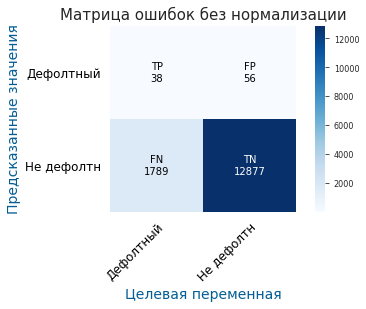

In [52]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

### ROC-AUC Кривая

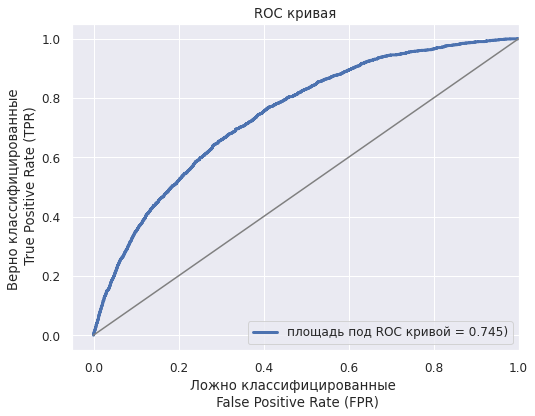

In [53]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

Несмотря на хорошие показатель ROC-AUC мы очень плохо угадали дефолтных клинетов, что видно по confusion-matrix и метрике F1

### Precision-Recall кривая

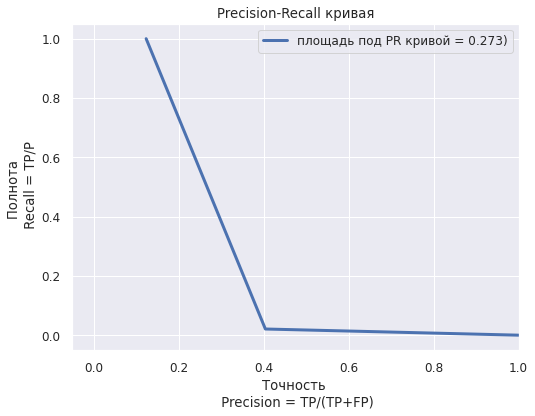

In [54]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


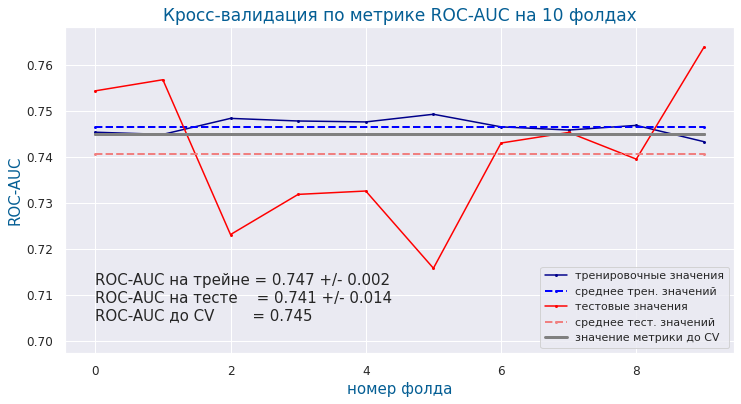

In [55]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

***Резюме*** - модель, которую мы получили, очень плохая, несмотря на то, что целевая метрика ROC-AUC достаточно высокая (=0.745).  
Потому что:
- Из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (38 из 1789). Об этом также свидетествует метрика полнота recall = 0.020799, которая собственно описывает этот момент. Таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка, так как мы будем выдавать кредиты людям которые их не смогут вернуть - риск потерять все деньги. 
- Но целевая переменная площадь под ROC кривой оказалась не такой уж плохой. Дело в том, что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных, поэтому мы добавили Precision-Recall кривую и увидели что эффективность нашего алгоритма оставляет желать лучшего.  

Кросс валидация показала дисперсию ошибки на тесте 0.014 и так как мы не использовали перемешивания, то можно сказать что модель лучше работает на крайних фолдах, чем на средних. В анализе признака data приводилась аналитика, которая говорила о том что вероятно в середине периода в банке проводилась какая-то акция и порог выдачи кредита снижался. Но мы в своей работе стремились создать надежный алгоритм который снижает ошибку второго рода (снижает потери банка) и достаточно стабильно работает (f1, PRC_AUC) при оптимальных значениях точности, а не гнались за просто высоким результатом на лидерборде.

### Поиск оптимальных параметров модели

In [56]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6687
Precision: 0.2256
Recall: 0.6891
F1: 0.3399


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***Резюме*** - метрика f1 подросла почти в 10 раз, что вселяет надежду на то, что модель теперь будет работать эффективнее. Построим модель на этих параметрах и посмотрим, но сначала заново пересоберем трейн и тест перемешав выборку

In [57]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Оценка качества модели на оптимальных параметрах 

### Матрица ошибок

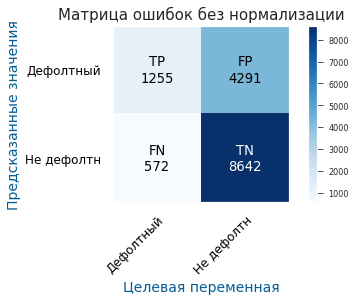

In [58]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

### ROC-AUC Кривая

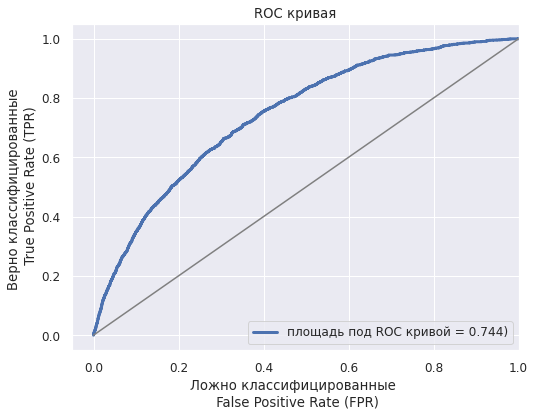

In [59]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

### Precision-Recall кривая

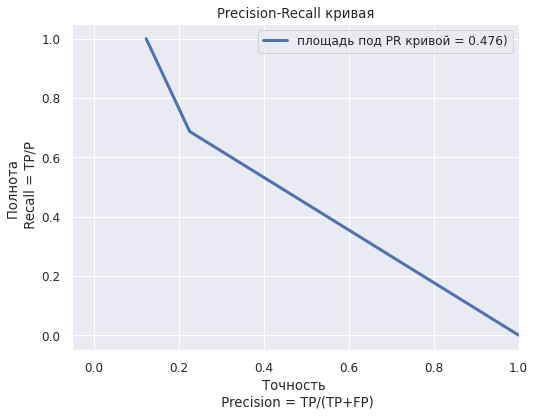

In [60]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

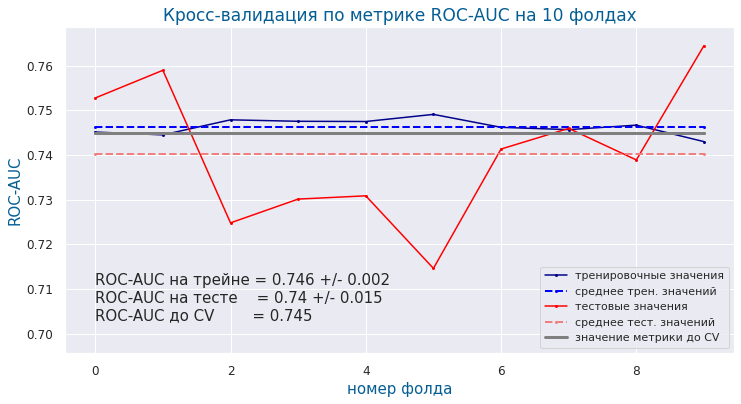

In [61]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

#### Сравнение с предыдущей моделью  
Recall (до 0.68 с 0.022) и f1 (до 0.34) заметно выросли, Precision, Accuracy упали, ROC-AUC остался почти на том-же месте.  Мы можем ожидать уменьшение ошибки второго рода, что видно из матрицы. Модель должна лучше себя вести на менее сбалансированных данных. Дисперсия не изменилась на кросс-валидации, так-что можно еще можно попробовать оптимизировать модель: подобрать параметры или убрать некоторые признаки. 

### Проверка нулевых коэффициэнтов при регуляризации первого порядка

In [62]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

display(model_coef(X_train.columns, model.coef_[0]))

,имя признака,коэффициент модели
0,score_bki,0.972922
1,region_rating_80,-0.752233
2,region_rating_20,0.692989
3,education_1,0.678450
4,region_rating_30,0.580220
5,home_address_2,0.530877
6,education_2,0.527620
7,region_rating_70,-0.425688
8,decline_app_cnt,0.411107
9,work_address_3,0.407047


***Резюме*** - влияние score_bki самое большое, следом идут разные значения рейтинга региона, школьное образование, кол-во отказов.  
Кандидаты на удаление:
- work_address_1
- home_address_1
- sna_3
- region_rating_60
- first_time_3
- education_4
- income
- days
- car
- sna_2
- home_address_3

In [63]:
# формируем список отсева признаков
drop_list1 = ['work_address_1', 'home_address_1', 'sna_3', 'region_rating_60', 'first_time_3', 'education_4',
                  'income','days','sna_2','home_address_3']

In [64]:
#заново формируем выборки для обучения без этих признаков
train = df.query('Train == 1').drop(['Train', 'client_id']+drop_list1, axis=1)
test = df.query('Train == 0').drop(['Train', 'client_id']+drop_list1, axis=1)

X = train.drop(['default'], axis=1)
y = train.default.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Проверка качества модели после удаления признаков

In [65]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= -1, 
                           penalty= 'none', 
                           solver = 'newton-cg', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6654
Precision: 0.2232
Recall: 0.6869
F1: 0.3370


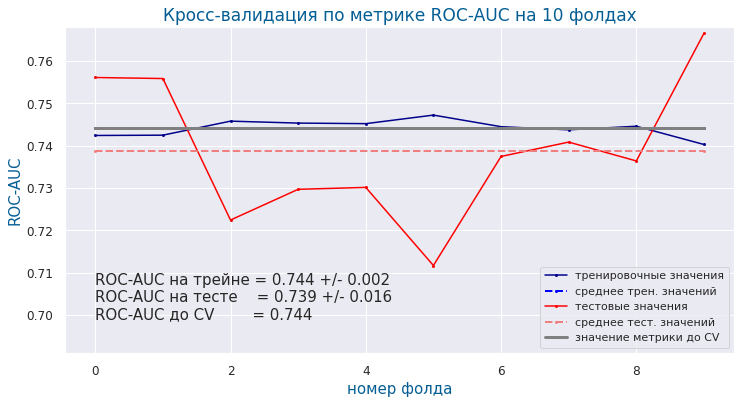

In [66]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

Дисперсия в кросс-валидации не изменилась, метрики F1, Recall, Precision уменьшились на тясячные

## Submission

In [67]:
train = df.query('Train == 1').drop(['Train', 'client_id']+drop_list1, axis=1)
test = df.query('Train == 0').drop(['Train', 'client_id']+drop_list1, axis=1)

In [68]:
X_train=train.drop(['default'], axis=1)
y_train = train.default.values
X_test = test.drop(['default'], axis=1)

In [69]:
# проверяем
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 28), (73799, 28), (73799, 27), (73799,), (36349, 27))

In [70]:
LogisticRegression(C=2.15, 
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='saga', 
                           random_state=RANDOM_SEED,
                           max_iter = 2000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]

In [71]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)